Complete the exercises below For **Assignment #4**.

Use **Markdown** cells for the non-code answers.

In this assignment we will work with the data underlying the *FiveThirtyEight* article ["Higher Rates Of Hate Crimes Are Tied To Income Inequality"](https://fivethirtyeight.com/features/higher-rates-of-hate-crimes-are-tied-to-income-inequality/).

Load the `tidymodels`, `readr`, and `moderndive` packages in the cell below.

In [7]:
library(tidymodels)

library(readr)

library(moderndive)

We can read the data from a **CSV file** at the following URL: [http://bit.ly/2ItxYg3](http://bit.ly/2ItxYg3).

Use the `read_csv` function to read the data into our R session. Call the new table `hate_crimes`.

In [ ]:
hate_crimes <- read_csv("http://bit.ly/2ItxYg3")

spec(hate_crimes)

Rows: 51 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): state, median_house_inc, trump_support, unemployment, urbanization
dbl (4): share_pop_metro, hs, hate_crimes, income

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


cols(
  state = col_character(),
  median_house_inc = col_character(),
  share_pop_metro = col_double(),
  hs = col_double(),
  hate_crimes = col_double(),
  trump_support = col_character(),
  unemployment = col_character(),
  urbanization = col_character(),
  income = col_double()
)

Next, let’s add the high-school degree variable into the mix by creating a scatterplot showing:

- Income on the y-axis (this is the `income` variable)
- Percent of adults 25 or older with a high school degree on the x-axis (this is the `hs` variable)
- The points colored by level of urbanization in a region (this is the variable `urbanization`)


**In addition, add a line of best fit (regression line) for each level of the variable urbanization (one for “low”, one for “high”).**

*Add the regression lines to the plot using the `geom_parallel_slopes` function from the `moderndive` package. This function will draw the regression lines based on fitting a regression model with parallel slopes (i.e., with no interaction between `hs` and `urbanization`).*

❓Which regression line (high urbanization or low urbanization) appears to have the larger intercept?

**Answer:**

The regression line associated with 'high urbanization' has a larger intercept.


Now let’s create a second scatterplot using the same variables, but this time draw the regression lines using `geom_smooth(method = "lm")`, which will allow for separate, non-parallel slopes for each urbanization group. 

**Code your scatter plot in the cell below.**

`geom_smooth()` using formula = 'y ~ x'
Warning message:
"Removed 3 rows containing non-finite outside the scale range (`stat_smooth()`)."


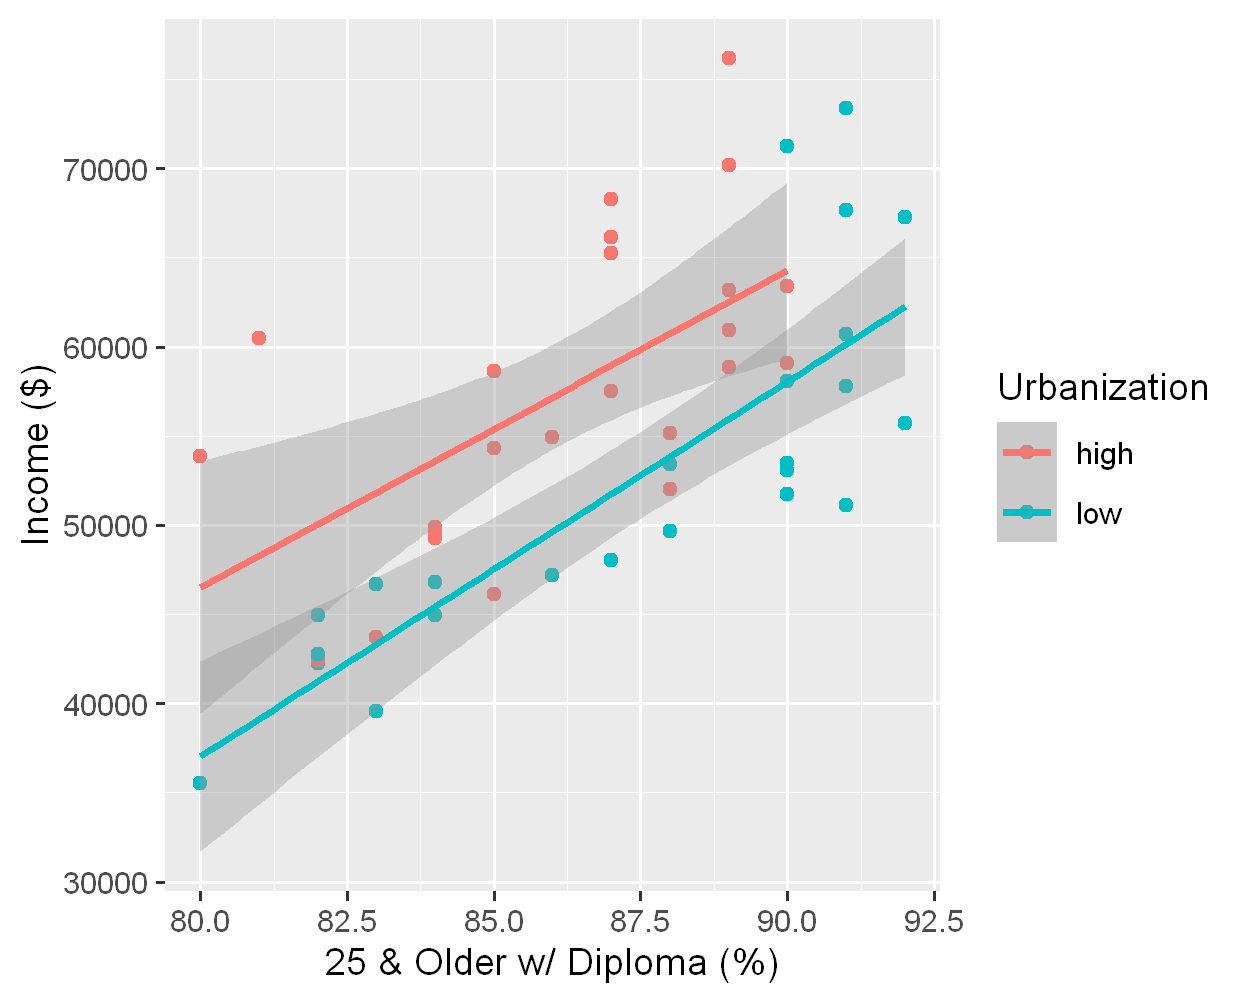

In [ ]:
ggplot(hate_crimes, aes(x = hs, y = income, color = urbanization)) +
  geom_point(na.rm = TRUE) +
  geom_smooth(method = "lm") +
  labs(
    x = "25 & Older w/ Diploma (%)",
    y = "Income ($)",
    color = "Urbanization"
  )

❓Based on visually comparing the two models shown above, do you think it would be best to run a “parallel slopes” model (i.e. a model that estimates one shared slope for the two levels of urbanization), or a more complex “interaction model” (i.e. a model that estimates a separate slope for the two levels of urbanization)?

**Answer:**

The 'interaction model' gives a more accurate picture of the relationship.


Fit the following two regression models that examine the relationship between household `income` (as response variable), and high-school education (`hs`) and `urbanization` as explanatory variables:

1. A parallel slopes model (i.e., no interaction between `hs` and `urbanization`). ❗️Save the data recipe and model under the variables `ps_rec` and `ps_mod`, respectively. 
1. A non-parallel slopes model (i.e., allow `hs` and `urbanization` to interact in your model). ❗️Save the data recipe and model under the variable: `nps_rec` and `nps_mod`, respectively.

**Code you your models in the cell below.**

In [ ]:
# parallel slopes model



ps_rec <- recipe(income ~ hs + urbanization,
  data = hate_crimes
) |>
  step_naomit(everything()) |> # remove missing values

  step_dummy(urbanization) |> # dummy encode the urbanization variable

  prep() # run the recipe on the training data provided



mod <- linear_reg() |> set_engine("lm")



ps_train <- juice(ps_rec)

ps_mod <- mod |> fit(income ~ ., data = ps_train)



tidy(ps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-113725.193,23552.9187,-4.828497,1.624694e-05
hs,1986.794,272.9303,7.279490,3.930730e-09
urbanization_low,-7333.326,1857.6592,-3.947616,2.744526e-04


In [ ]:
# non-parallel slopes model



# ❗️ you can use most of the code above, just add step_interact(~
# starts_with("urbanization"):hs) to the recipe and

#    switch the variable names...



nps_rec <- recipe(income ~ hs + urbanization,
  data = hate_crimes
) |>
  step_naomit(everything()) |> # remove missing values

  step_dummy(urbanization) |> # dummy encode the urbanization variable

  step_interact(~ starts_with("urbanization"):hs) |>
  prep() # run the recipe on the training data provided



mod <- linear_reg() |> set_engine("lm")



nps_train <- juice(nps_rec)

nps_mod <- mod |> fit(income ~ ., data = nps_train)



tidy(nps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-95647.4274,39937.8800,-2.3949050,0.0209485906
hs,1776.9938,463.2497,3.8359312,0.0003953977
urbanization_low,-35393.9651,49893.5228,-0.7093900,0.4818248864
urbanization_low_x_hs,323.9987,575.6838,0.5628067,0.5764231616


The following code creates a table of your model predictions over the training data. Calculate the [coefficient of determination](https://en.wikipedia.org/wiki/Coefficient_of_determination) (R<sup>2</sup>) for each model:

```r
rbind(
    augment(ps_mod, juice(ps_rec)) |> select(income, .pred, .resid) |> mutate(model = "parallel_slopes"),
    augment(nps_mod, juice(nps_rec)) |> select(income, .pred, .resid) |> mutate(model = "interaction")
)
```

1. Group rows by the `model` variable (use the `group_by` function).
1. Calculate the variance of income over the variance of your predictions for each model using the "grouped" data from the step above (use `summarize(r_squared = var(.pred) / var(income))`).

In [ ]:
model_data <- bind_rows(
  augment(ps_mod, ps_train) |>
    select(income, .pred, .resid) |>
    mutate(model = "parallel_slopes"),
  augment(nps_mod, nps_train) |>
    select(income, .pred, .resid) |>
    mutate(model = "interaction")
)



r2_table <- model_data |>
  group_by(model) |>
  summarize(
    r_squared_resid = 1 - var(.resid, na.rm = TRUE) / var(income, na.rm = TRUE),
    r_squared_cor = cor(income, .pred, use = "complete.obs")^2,
    .groups = "drop"
  )



r2_table

model,r_squared
<chr>,<dbl>
interaction,0.5746731
parallel_slopes,0.5716112


🎶 Note: you can also use the `glance` function with a model as input to find the coefficient of determination.

In [38]:
mod_summary <- glance(ps_mod)
nmod_summary <- glance(nps_mod)
mod_rsq <- mod_summary$r.squared
nmod_rsq <- nmod_summary$r.squared

mod_rsq
nmod_rsq

[1] 0.5716112

[1] 0.5746731

❓Compare the adjusted proportion of variance accounted for in each model. Based on this comparison, which model do you prefer? Why? 

**Answer:**

Based on the adjusted proportion of variance accounted for in each model, the higher r^2 value for the interaction model confirms it as the more accurate model.



❓Using your preferred model, based on your regression model parameters (and the data visualizations), is `income` greater in states that have lower or higher levels of `urbanization`? By how much?

**Hint:** use the `tidy` function with your model as input to access the parameters in a nice table.

**Answer:**

In [42]:
tidy(nps_mod)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-95647.4274,39937.8800,-2.3949050,0.0209485906
hs,1776.9938,463.2497,3.8359312,0.0003953977
urbanization_low,-35393.9651,49893.5228,-0.7093900,0.4818248864
urbanization_low_x_hs,323.9987,575.6838,0.5628067,0.5764231616


❓For every one percentage point increase of high-school educated adults in a state (`hs` variable), what is the associated average increase in `income`?

**Answer:**

In [ ]:
model_hs <- lm(income ~ hs, data = hate_crimes)
tidy(model_hs)
coef(model_hs)["hs"]

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-100218.287,26743.1172,-3.747442,4.972308e-04
hs,1788.923,307.8934,5.810201,5.570303e-07


hs 
1788.923